<a href="https://colab.research.google.com/github/jtorom/jtorom/blob/develop/Rocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importaci n Libreria de Google Drive
from google.colab import drive
#Acceso al directorio de Drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')
#Descarga de las librerias de Mask RCNN de matterport
#!git clone https://github.com/matterport/Mask_RCNN
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN'):
  !git clone https://github.com/masc-it/Mask-RCNN.git


Mounted at /content/drive


In [2]:
%cd Mask-RCNN
!pip list
!pip3 install -r requirements.txt
!python3 setup.py install

/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN
Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4   

In [3]:
#Descarga de la matriz de pesos COCO.h5
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/cocoapi'):
  !git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../


/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.10/dist-packages/numpy/core/include -I../common -I/usr/include/python3.10 -c ../common/maskApi.c -o build/temp.linux-x86_64-cpython-310/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wmisleading-indentation-Wmisleading-indentation]8;;]
   46 |       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=

In [7]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)





In [ ]:
import skimage as ski
print(ski.__version__)

if not (ski.__version__=="0.16.2"):
  !pip uninstall --yes scikit-image
  !pip install scikit-image==0.16.2
  os.kill(os.getpid(), 9)

0.19.3
  Using cached scikit-image-0.16.2.tar.gz (28.9 MB)
  Preparing metadata (setup.py) ... done


In [44]:

import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import imgaug
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense,Flatten , Conv2D , MaxPooling2D , Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


In [45]:
ROOT_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis')

sys.path.append(ROOT_DIR)

In [46]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/')
from mrcnn.config import Config
from mrcnn import utils
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/Mask-RCNN/mrcnn/')
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
%matplotlib inline

In [47]:
# Directorio donde se guaradaran los logs y los modelos de entrenamiento [en root dir- logs]
MODEL_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs')
# Directorio donde se guardara el archivo de pesos COCO.h5
COCO_MODEL_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs/mask_rcnn_coco.h5')


In [48]:
# Se comprueba que se haya descargado correctamente el archivo COCO.h5
if os.path.exists(os.path.join(COCO_MODEL_PATH)):
  print("coco model exist")
%cd /content/drive/MyDrive/Colab Notebooks/WorkspaceTesis
!ls

coco model exist
/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis
 8433365521_9252889f9a_z.jpg			       events.out.tfevents.1700080742.48232b430e14
 ColorPanoptic.png				      'Kaggle y Maskrcnn.ipynb'
 convnext_large_kmax_deeplab_coco_train_unlabeled      logs
 convnext_large_kmax_deeplab_coco_train_unlabeled.gz   Mask-RCNN
 data						       mask_rcnn_coco.h5
 DeeepLab_COCO.py				       sample2.jpg
 DeepLab_COCO.ipynb				       sphx_glr_plot_visualization_utils_001.png
 deeplabv3_xception_tf_dim_ordering_tf_kernels.h5


In [49]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
DATA_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/')

In [68]:
#Craci n de los directorios de validaci n , test y train
os.chdir('/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/')
DATASET_TRAIN_DIR=os.path.join(DATA_DIR,'Train')
DATASET_VAL_DIR=os.path.join(DATA_DIR,'Validation')
DATASET_TEST_DIR=os.path.join(DATA_DIR,'Test')


#Crea com una configuraci n a partir de tensorflow, ConfigProto()
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



Physical devices cannot be modified after being initialized


In [51]:
path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train'
imageSize = [320, 512]
def ajustarTamano(path):
  os.chdir(path)
  for i,f in enumerate(os.listdir('.')):

    file_name, file_extension = os.path.splitext(f)
    #print(file_extension)
    if os.path.isfile(f) and file_extension=='.jpg':

      image_path_jpg = f
      #print(image_path_jpg)
      img = tf.io.read_file(image_path_jpg)
      #print(img.get_shape().as_list()) # []
      img = tf.image.decode_jpeg(img)
      #print(img.get_shape().as_list())
      img_resized = tf.image.resize(img, (imageSize))
      img_resized = img_resized.eval(session=session)
      #print(type(img_resized))
      img_resized_tensor = tf.reshape(img_resized, [imageSize[0], imageSize[1],1] )
      img_resized = img_resized_tensor.eval(session=session)
      cv2.imwrite(f, img_resized)

path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Train'
ajustarTamano(path)
path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Test'
ajustarTamano(path)
path='/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/data/Validation'
ajustarTamano(path)

In [52]:
#Creaci n de las clases partiendo de config
class Rocks(Config):
  # Definici n de la clase general
  NAME ="rock"
  # Se ajusta n mero de imagenes a cada GPU.
  IMAGES_PER_GPU = 1
  # Defino n m e r o de clases incluyendo el background
  NUM_CLASSES = 2 #Background + rock"
  # Numero de steps por cada epoca
  STEPS_PER_EPOCH = 1 # Se pone el mismo n mero de imagenes que hay en la carpeta Train
  # Precisi n del sistema (en el proceso de validaci n)
  DETECTION_MIN_CONFIDENCE = 0.75
  # MiniMask
  USE_MINI_MASK = True
  #imageSize = [536, 350]
  IMAGE_SHAPE = imageSize
  BATCH_SIZE =1
  LEARNING_RATE=0.005

In [53]:
config = Rocks()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [54]:
from PIL import Image,ImageDraw
axis_Width = 15

In [55]:
#Hereda de la clase Dataset en el fichero utils.
class RocksDataset(utils.Dataset):

  def load_dataset(self, dataset_dir):

    self.add_class('dataset', 1, 'rock')

    for i, filename in enumerate(os.listdir(dataset_dir)):
      annotation_file = os.path.join(dataset_dir , filename.replace('.jpg', '.json'))
      if '.jpg' in filename and os.path.isfile(annotation_file):
        self.add_image('dataset',image_id=i,path=os.path.join(dataset_dir , filename),annotation=annotation_file)

  def extract_masks(self, filename):
    json_file = os.path.join(filename) #Devuelve el nombre del fichero con string->’.
    with open(json_file) as f:
      img_anns = json.load(f)
    n_masks = 0
    for anno in img_anns['shapes']:
      if anno['label']=='rock':
        n_masks+=1#
    masks = np.zeros([img_anns['imageHeight'], img_anns['imageWidth'], n_masks], dtype='uint8')
    classes = []#
    i=0
    for anno in img_anns['shapes']:
      if anno['label']=='rock':
        mask = np.zeros([img_anns['imageHeight'], img_anns['imageWidth']], dtype=np.uint8)
        cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
        masks[:, :, i] = mask
        classes.append(self.class_names.index(anno['label']))
        i+=1
    return masks , classes

  # Carga las m scaras para una imagen
  def load_mask(self, image_id):
    info = self.image_info[image_id]
    path = info['annotation']
    masks, classes = self.extract_masks(path)
    return masks, np.asarray(classes, dtype='int32')

  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']




In [56]:
dataset_train = RocksDataset()
dataset_train.load_dataset(DATASET_TRAIN_DIR)
dataset_train.prepare()


In [57]:
#Para comprobar que las imagenes se han cargado bien
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
  print("{:3}. {:50}".format(i, info['name']))


Image Count: 31
Class Count: 2
  0. BG                                                
  1. rock                                              


In [58]:
# Validation set
dataset_val = RocksDataset()
dataset_val.load_dataset(DATASET_VAL_DIR)
dataset_val.prepare()

In [59]:
#Para comprobar que las imagenes se han cargado bien
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
  print("{:3}. {:50}".format(i, info['name']))

Image Count: 1
Class Count: 2
  0. BG                                                
  1. rock                                              


In [60]:
#Test set
dataset_test = RocksDataset()
dataset_test.load_dataset(DATASET_TEST_DIR)
dataset_test.prepare()
print('Test: %d images' % len(dataset_test.image_ids))

Test: 1 images


In [61]:
#Para comprobar que las imagenes se han cargado bien
print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
  print("{:3}. {:50}".format(i, info['name']))


Image Count: 1
Class Count: 2
  0. BG                                                
  1. rock                                              


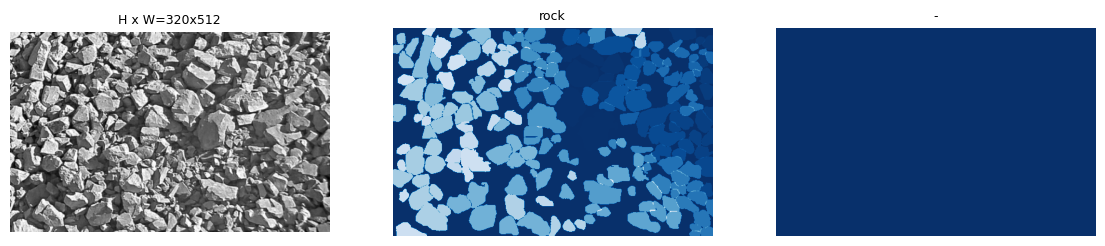

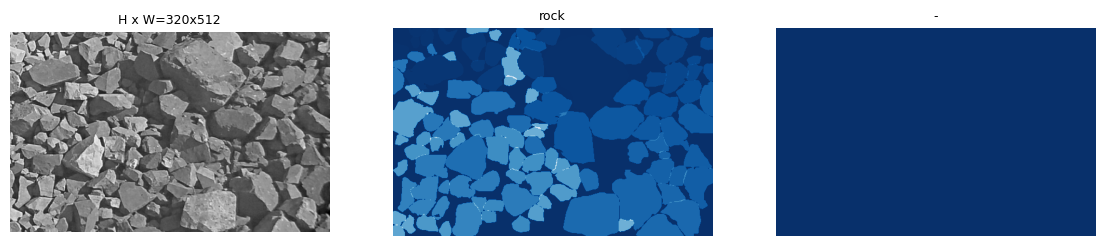

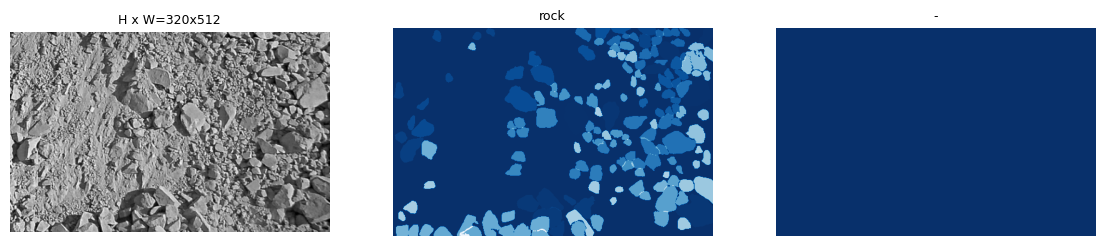

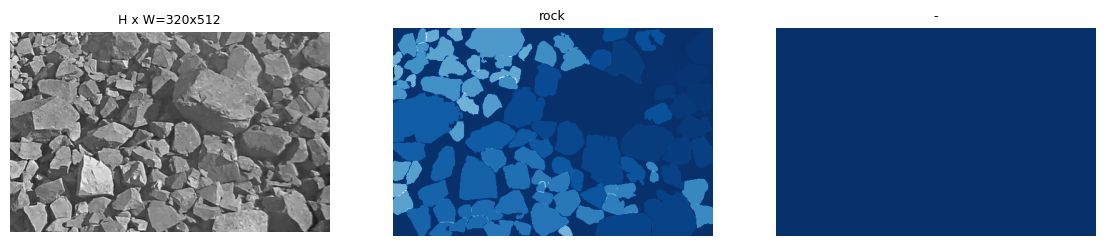

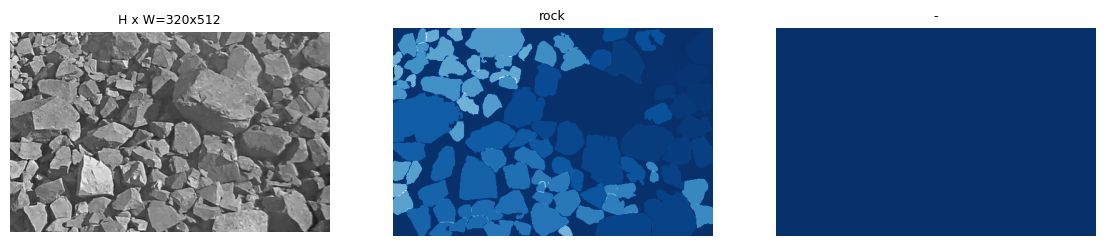

In [62]:
#Selecciona 5 im genes aleatorias i las visualiza con sus correspondientes m scaras
image_ids=np.random.choice(dataset_train.image_ids,5)
for image_id in image_ids:
  image = dataset_train.load_image(image_id)
  mask, class_ids = dataset_train.load_mask(image_id)
  visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,2)





In [63]:
# Crea el modelo del tarining mode
model = modellib.MaskRCNN(mode="training", config=config , model_dir=MODEL_DIR)
#model.find_last()

In [64]:
#Selecci n de las matrices de peso (coco o la ltima conseguida)
init_with = "coco"

In [65]:
if init_with == "imagenet":
  model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
  #Excluyo par metros que no me interesan
  model.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
  model.load_weights(model.find_last(), by_name=True)
  !pip list


In [66]:
Rock_augmentation = imgaug.augmenters.Sometimes(0.5,[imgaug.augmenters.geometric.Affine(rotate=(-360,360))])


In [30]:
model.train(dataset_train , dataset_val , learning_rate=config.LEARNING_RATE ,epochs=1,layers='heads',augmentation = Rock_augmentation)



Starting at epoch 0. LR=0.005

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs/rock20231116T0402/mask_rcnn_rock_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistri

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.10/dist-packages/imgaug/augmenters/base.py:49: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (1084, 1072, 113) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  ia.warn(
/usr/local/lib/python3.10/dist-packages/imgaug/augmenters/base.py:49: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (1084, 1072, 176) as a single-image augmentation input, which was interpreted as (H,

1/1 [==============================] - 3020s 3020s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 5.4293 - rpn_class_loss: 1.9255 - rpn_bbox_loss: 0.5898 - mrcnn_class_loss: 0.8257 - mrcnn_bbox_loss: 1.2565 - mrcnn_mask_loss: 0.8319 - val_loss: 3.9994 - val_rpn_class_loss: 0.8394 - val_rpn_bbox_loss: 0.5810 - val_mrcnn_class_loss: 1.1305 - val_mrcnn_bbox_loss: 0.7640 - val_mrcnn_mask_loss: 0.6846


In [67]:
model.train(dataset_train , dataset_val , learning_rate=config.LEARNING_RATE / 10,epochs=3, layers="all")


Starting at epoch 0. LR=0.0005

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/logs/rock20231116T0501/mask_rcnn_rock_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2

KeyboardInterrupt: ignored

In [ ]:
class InferenceConfig(Rocks):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1


In [ ]:
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", config=inference_config ,model_dir=MODEL_DIR)

In [ ]:
model_path = model.find_last()
print("Loading weights from ", model_path)
model.load_weights(model_path , by_name=True)

In [ ]:
def get_ax(rows=1, cols=1, size=2):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

dataset_val.image_ids

In [80]:
image_id=2
#original_image , image_meta , gt_class_id ,gt_bbox , gt_mask = modellib.load_image_gt(dataset_val , inference_config , image_id , use_mini_mask=False)
original_image , image_meta , gt_class_id ,gt_bbox , gt_mask = modellib.load_image_gt(dataset_val , inference_config , image_id)


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

IndexError: ignored

In [67]:
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names, figsize=(8, 8))
print(gt_class_id.shape)

NameError: ignored

In [68]:
results = model.detect([original_image], verbose=1)

NameError: ignored

In [ ]:
r = results[0]
visualize.display_instances(original_image , r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())
print(r['class_ids'].shape)

In [ ]:
from mrcnn import utils
from mrcnn import utils_confusion
import pandas as pd
import numpy as np
import os
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

In [ ]:
for image_id in dataset_test.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
   modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
  info=dataset_test.image_info[image_id]

  results = model.detect([image], verbose=1)
  r = results[0]

  gt, pred = utils_confusion.gt_pred_lists(gt_class_id,gt_bbox, r['class_ids'],  r['rois'])

  gt_tot = np.append(gt_tot, gt_class_id)
  pred_tot=np.append(pred_tot, pred)

  AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,r['rois'], r['class_ids'], r['scores'], r['masks'])

  print("the actual len of the gt vect is : ", len(gt_tot))
  print("the actual len of the pred vect is : ", len(pred_tot))

  mAP_.append(AP_)

In [ ]:
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
  os.makedirs(save_dir)
df.to_json(os.path.join(save_dir ,"gt_pred_test.json"))

In [ ]:
print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)
tp,fp,fn=utils_confusion.plot_confusion_matrix_from_data(gt_tot,pred_tot,fz=18, figsize=(20,20), lw=0.5)

In [ ]:
#Se extraen los datos de p r d i d a s y se muestran con el tensorflow
import tensorflow.compat.v1 as tf
%load_ext tensorboard
sess = tf.Session()
path_logs = "/content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/"
file_writer = tf.summary.FileWriter( path_logs , sess.graph )
%tensorboard --logdir /content/drive/MyDrive/Colab Notebooks/WorkspaceTesis/